This notebook shows the pipeline from target book > ANN-derived candidate books > Relationship classificaton.

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import numpy as np
import logging
from compare_tools.MTAnnoy import MTAnnoy
from compare_tools.hathimeta import HathiMeta
from compare_tools.utils import HTID
from compare_tools.comparison import HTIDComparison
from compare_tools.configuration import config, init_htid_args
import argparse
import time
import os

In [208]:
hargs = init_htid_args(config)
meta = hargs['hathimeta']
metadf = pd.read_csv(config['meta_path'])
def make_clickable(val):
    return '<a target="_blank" href="http://hdl.handle.net/2027/{}">{}</a>'.format(val, val)
ann = MTAnnoy(config['ann_path'], dims=300)

In [186]:
def get_simmats(htid, ann, reshape=False):
    '''
    For a target HTID, find match candidates with ANN, then return the target-candidate similarity matrices. Sim mats are unrolled, unless reshape argument is given. 
    '''
    left = HTID(htid, **hargs)
    results = ann.doc_match_stats(htid, n=300, min_count=3, max_dist=0.25)

    rightindex = []
    allsims = []
    for rightid in results.match.unique():
        if htid == rightid:
            continue
        right = HTID(rightid, **hargs)
        comp = HTIDComparison(left, right)
        try:
            sims = comp.unrolled_sim()
            if reshape:
                sims = sims.reshape(reshape)
            rightindex.append(rightid)
            allsims.append(sims)
        except:
            continue
    allsims = np.stack(allsims)
    return rightindex, allsims

In [187]:
%%time
target = meta.random()
target = meta['mdp.35112101274639']
rightindex, allsims = get_simmats(target['htid'], ann, (50,50,1))
print(allsims.shape, target['title'], target['author'], target['description'])

(354, 50, 50, 1) The treaty making power of the United States, Butler, Charles Henry, 1859-1940. v. 1
CPU times: user 8.32 s, sys: 103 ms, total: 8.42 s
Wall time: 8.43 s


In [181]:
metadf.groupby(['author', 'title', 'description'])[['htid']].count().sort_values('htid', ascending=False).iloc[10:20]

htid
author                                     title                                              description      
Taylor, Henry Osborn, 1856-1941.           Thought and expression in the sixteenth century... v.2             7
FitzGerald, Edward, 1809-1883.             Letters of Edward FitzGerald ...                   v.1             7
Taylor, Henry Osborn, 1856-1941.           Thought and expression in the sixteenth century... v.1             7
Jacobson, Nathan, 1910-1999.               Lectures in abstract algebra.                      v.2             7
Herbertson, A. J. 1865-1915.               The Oxford survey of the British Empire ... edi... v.6             7
Butler, Charles Henry, 1859-1940.          The treaty making power of the United States,      v.1             7
                                                                                              v.2             7
Minto, Gilbert Elliot, Earl of, 1751-1814. Life and letters of Sir Gilbert Elliot, first e... v.2             7
Iowa. Governor (1917-1921 : Harding)       Inaugural address of William L. Harding, Govern... v.1             7
Minto, Gilbert Elliot, Earl of, 1751-1814. Life and letters of Sir Gilbert Elliot, first e... v.1             7

### PARTOF

Todo - test on books named 'works'

## Classify

In [183]:
#import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Reshape, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from compare_tools.train_utils import judgment_labels, judgment_label_ref

Note to self - saving TF format caused problems (TPU didn't save variables?). Saving H5 remotely didn't work, so I saved locally (needs full ./path location), downloaded, and reuploaded here.

In [161]:
from google.cloud import storage
client = storage.Client.create_anonymous_client()
bucket = client.bucket(bucket_name="porganized-1", user_project=None)

model_path = 'books/models/export/cnn_w_drop_alllabel_acc84.tf'
os.makedirs('/data/saddl/models/', exist_ok=True)
local_model_path = os.path.join('/data/saddl/models/', os.path.split(model_path)[-1])

def move_gcs_dir(path, target):
    if not path.endswith('/'):
        path = path + '/'
    print(path.upper(), target.upper())
    for x in bucket.list_blobs(prefix=path):
        if x.name == path:
            continue
        if x.name.endswith('/'):
            print('making dir', x.name)
            new_dir = os.path.join(target, x.name.split('/')[-2])
            os.makedirs(new_dir, exist_ok=True)
            move_gcs_dir(x.name, new_dir)
        else:
            fname = os.path.join(target, os.path.split(x.name)[-1])
            x.download_to_filename(filename=fname, client=client)
            
move_gcs_dir(model_path, local_model_path)

BOOKS/MODELS/EXPORT/CNN_W_DROP_ALLLABEL_ACC84.TF/ /DATA/SADDL/MODELS/CNN_W_DROP_ALLLABEL_ACC84.TF
making dir books/models/export/cnn_w_drop_alllabel_acc84.tf/assets/
BOOKS/MODELS/EXPORT/CNN_W_DROP_ALLLABEL_ACC84.TF/ASSETS/ /DATA/SADDL/MODELS/CNN_W_DROP_ALLLABEL_ACC84.TF/ASSETS
making dir books/models/export/cnn_w_drop_alllabel_acc84.tf/variables/
BOOKS/MODELS/EXPORT/CNN_W_DROP_ALLLABEL_ACC84.TF/VARIABLES/ /DATA/SADDL/MODELS/CNN_W_DROP_ALLLABEL_ACC84.TF/VARIABLES


In [162]:
model = load_model('/data/saddl/models/cnn_w_drop_alllabel_acc84.h5')

In [379]:
def get_model_predictions(rightindex, allsims):
    predictions = model.predict(allsims)
    predictions = pd.DataFrame(predictions, columns=judgment_labels)
    predictions['htid'] = rightindex
    best_predictions = np.argmax(predictions[judgment_labels].values, axis=1)
    predictions['guess'] = [judgment_labels[i] for i in best_predictions]
    predictions = predictions.sort_values(judgment_labels, ascending=False)
    predictions = predictions.merge(metadf[['htid', 'title','description','author', 'rights_date_used', 'oclc_num', 'isbn']], on='htid')
    predictions['relatedness'] = np.average(predictions[judgment_labels], weights=[1,.7,.7,.6,.6,.3,.1], axis=1) # Weighted average of probabilities, with emphasis on SWSM
    return predictions

def export_structured_data(target, predictions):
    base_meta = ['htid', 'title', 'author', 'description', 'rights_date_used', 'oclc_num', 'isbn']
    data_entry = dict(volume=target[base_meta].to_dict())
    data_entry['volume']['link'] = "http://hdl.handle.net/2027/" + target['htid']
    data_entry['related_metadata'] = dict()
    data_entry['relationships'] = dict()
    data_entry['recommendations'] = dict()

    by_author = predictions[predictions.author == target.author]
    # Add Collected Metadata
    def unique_nontarget_values(field, limit=['SWSM', 'SWSE'], df=by_author):
        diff = (df[field] != target[field]) if target[field] else True
        uniq = df[df.guess.isin(limit) & diff][field].unique().tolist()
        return uniq if len(uniq) else []
    data_entry['related_metadata']['other years'] = unique_nontarget_values('rights_date_used')
    data_entry['related_metadata']['other titles'] = unique_nontarget_values('title')
    data_entry['related_metadata']['other OCLC numbers'] = unique_nontarget_values('oclc_num')
    data_entry['related_metadata']['other enumchron values'] = unique_nontarget_values('description')
    data_entry['related_metadata']['titles within this work'] = unique_nontarget_values('title', ["CONTAINS"])
    data_entry['related_metadata']['titles of works that contain this work'] = unique_nontarget_values('title', ["PARTOF"])

    # Add Same Work Info
    def get_dict_by_guess(guess):
        a = by_author[by_author.guess == guess].sort_values(guess, ascending=False)
        if a.empty:
            return []
        a = a[base_meta + [guess]]
        a = a.rename(columns={'rights_date_used': 'year', guess: "confidence"})
        a['confidence'] = a['confidence'].multiply(100).astype(int)
        return a.to_dict(orient='records')
    
    data_entry['relationships']['identical works'] = get_dict_by_guess("SWSM")
    data_entry['relationships']['different expressions'] = get_dict_by_guess("SWDE")
    data_entry['relationships']['other volumes of the larger work'] = get_dict_by_guess("WP_DV")
    data_entry['relationships']['this work contains'] = get_dict_by_guess("CONTAINS")
    data_entry['relationships']['this work is a part of'] = get_dict_by_guess("PARTOF")
    
    sim_books = predictions[(predictions.author != target.author) & (predictions.relatedness > 0.15)].sort_values('relatedness').head(20)
    data_entry['recommendations']['related authors'] = unique_nontarget_values('author', judgment_labels, df=sim_books)
    data_entry['recommendations']['similar books'] = sim_books[base_meta].rename(columns={'rights_date_used': 'year'}).to_dict(orient='records')
    
    return data_entry

In [359]:
import json
data_entry = export_structured_data(target, predictions)
print(json.dumps(data_entry, indent=2))

{
  "volume": {
    "htid": "mdp.35112101274639",
    "title": "The treaty making power of the United States,",
    "author": "Butler, Charles Henry, 1859-1940.",
    "description": "v. 1",
    "rights_date_used": 1902.0,
    "oclc_num": "2607855",
    "isbn": null
  },
  "related_metadata": {
    "other years": [],
    "other titles": [],
    "other OCLC numbers": [],
    "other enumchron values": [
      "v.1",
      "v.1 (1902)"
    ],
    "titles within this work": [
      "The responsibility of Spain for the destruction of the United States battleship Maine in Havana harbor, February 15, 1898, and the assumption by the United States, under the treaty of 1898, of Spain's pecuniary liability for the injuries to, and deaths of, her officers and crew. Argument of Charles Henry Butler, before the Spanish treaty claims commission, December 18-21, 1901, on behalf of claimants represented by Butler & Harwood."
    ],
    "titles of works that contain this work": []
  },
  "relationships":

In [361]:
target = meta.random()
#target = meta['mdp.35112101274639']
rightindex, allsims = get_simmats(target['htid'], ann, (50,50,1))
predictions = get_model_predictions(rightindex, allsims)
data_entry = export_structured_data(target, predictions)
print(json.dumps(data_entry, indent=2))

{
  "volume": {
    "htid": "pst.000027940457",
    "title": "A history of the Inquisition of the Middle Ages.",
    "author": "Lea, Henry Charles, 1825-1909.",
    "description": "v.1",
    "rights_date_used": 1955.0,
    "oclc_num": "3066364",
    "isbn": null
  },
  "related_metadata": {
    "other years": [
      1887.0,
      1888.0,
      1922.0
    ],
    "other titles": [
      "A history of the Inquisition of the middle ages. By Henry Charles Lea ...",
      "A history of the Inquisition of the middle ages. By Henry Charles Lea.",
      "A history of the Inquisition of the middle ages / By Henry Charles Lea ..."
    ],
    "other OCLC numbers": [
      "1315744",
      "23350926",
      "4016729"
    ],
    "other enumchron values": [],
    "titles within this work": [],
    "titles of works that contain this work": []
  },
  "relationships": {
    "identical works": [
      {
        "htid": "uc2.ark:/13960/t7jq18r1z",
        "title": "A history of the Inquisition of the mid

In [385]:
metadf[metadf.title.str.contains('Works')][['htid', 'title', 'author']].drop_duplicates('author')

,htid,title,author
2028,uc1.32106009678852,[Works],"Wilde, Oscar, 1854-1900."
2984,uc2.ark:/13960/t8cf9nq4h,Works of Edward FitzGerald. Reprinted from the...,"FitzGerald, Edward, 1809-1883."
6973,uc1.b3649467,Works / by Augustus John.,"John, Augustus, 1878-1961."
7452,uc1.b3459562,[Works],"Spencer, Herbert, 1820-1903."
9505,hvd.32044105549166,"Works. With some account of his life, summary ...","Sherlock, Thomas, 1678-1761."
...,...,...,...
140572,uva.x004383836,[Works of Gautier] by Théophile Gautier ; tran...,"Gautier, Théophile, 1811-1872."
142118,pst.000002042121,The life and Works of John Heywood / by Robert...,"Bolwell, Robert George Whitney, 1891-"
142937,uc1.$b294600,"Works, by Dr. Bimala Churn Law ... Reviews & o...","Law, Bimala Churn, 1892-1969."
143058,mdp.39015021031185,The Michigan test road / published by Michigan...,Michigan. State Highway Dept.


In [400]:
metadf[metadf.author.str.contains('Shakespeare')][['htid', 'title', 'author']].sample(5)

,htid,title,author
30667,nyp.33433074899380,The dramatic works of William Shakspeare / wit...,"Shakespeare, William, 1564-1616."
30684,hvd.32044024425712,"Comedy of As You Like It. With preface, glossa...","Shakespeare, William, 1564-1616."
30708,hvd.hn3m6i,The works of Shakespeare: the text carefully r...,"Shakespeare, William, 1564-1616."
30712,umn.31951002085189e,"The works of Shakespeare / edited, with introd...","Shakespeare, William, 1564-1616."
30701,njp.32101067670750,The plays of William Shakspeare : complete in ...,"Shakespeare, William, 1564-1616."


In [ ]:
#Good examples
target = meta["uva.x004319990"]
target = meta["hvd.hn3m6i"]

In [413]:
left = HTID("uva.x004319990", **hargs)
right = HTID("inu.30000076448368", **hargs)
comp = HTIDComparison(left, right)
sims = comp.unrolled_sim().reshape(1, 50, 50, 1)

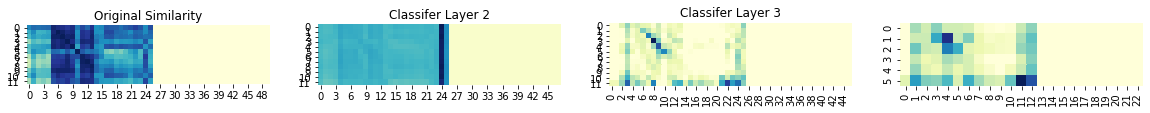

In [595]:
import matplotlib.pyplot as plt
import seaborn as sns

get_hidden_outputs = K.function([model.layers[0].input],
                                [model.layers[0].output, model.layers[1].output, model.layers[2].output])
layer_output = get_hidden_outputs([sims])

fig, axs = plt.subplots(1, 4, figsize=(20,10))
#fig.suptitle('Vertically stacked subplots')
axs[0].set_title('Original Similarity')
sns.heatmap(np.log(1+sims[0,:12,:,0]), vmin=0.65, square=True, ax=axs[0], cmap="YlGnBu", cbar=False)
axs[1].set_title('Classifer Layer 1')
sns.heatmap(layer_output[0][0,:12,:,:].mean(axis=2),  vmin=0.001, square=True, ax=axs[1], cmap="YlGnBu", cbar=False)
axs[1].set_title('Classifer Layer 2')
sns.heatmap(layer_output[1][0,:12,:,:].mean(axis=2),  vmin=0.001, square=True, ax=axs[2], cmap="YlGnBu", cbar=False)
axs[2].set_title('Classifer Layer 3')
sns.heatmap(layer_output[2][0,:6,:,:].mean(axis=2),  vmin=0.001, square=True, ax=axs[3], cmap="YlGnBu", cbar=False)

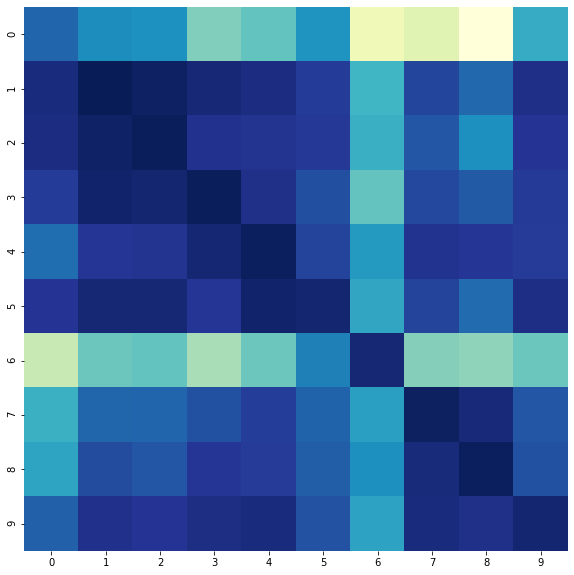

In [613]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
sns.heatmap(np.log(1+sims[0,:10,:10,0]), square=True, cmap="YlGnBu", cbar=False, ax=ax)

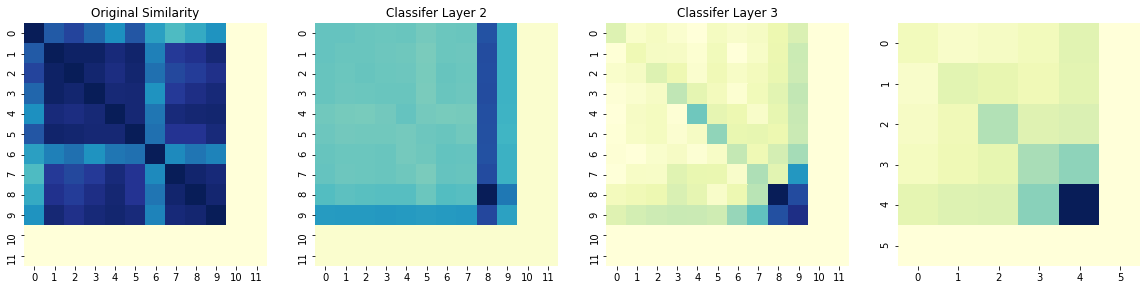

In [614]:
left = HTID("uva.x004319990", **hargs)
right = HTID("mdp.39015079150069", **hargs)
comp = HTIDComparison(left, right)
sims = comp.unrolled_sim().reshape(1, 50, 50, 1)

layer_output = get_hidden_outputs([sims])

fig, axs = plt.subplots(1, 4, figsize=(20,10))
#fig.suptitle('Vertically stacked subplots')
axs[0].set_title('Original Similarity')
sns.heatmap(np.log(1+sims[0,:12,:12,0]), vmin=0.65, square=True, ax=axs[0], cmap="YlGnBu", cbar=False)
axs[1].set_title('Classifer Layer 1')
sns.heatmap(layer_output[0][0,:12,:12,:].mean(axis=2),  vmin=0.001, square=True, ax=axs[1], cmap="YlGnBu", cbar=False)
axs[1].set_title('Classifer Layer 2')
sns.heatmap(layer_output[1][0,:12,:12,:].mean(axis=2),  vmin=0.001, square=True, ax=axs[2], cmap="YlGnBu", cbar=False)
axs[2].set_title('Classifer Layer 3')
sns.heatmap(layer_output[2][0,:6,:6,:].mean(axis=2),  vmin=0.001, square=True, ax=axs[3], cmap="YlGnBu", cbar=False)

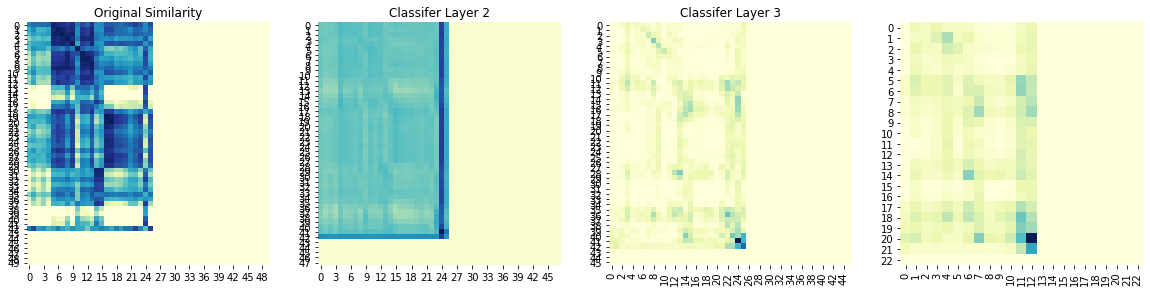

In [601]:
left = HTID("inu.30000076448368", **hargs)
right = HTID("mdp.39015012428309", **hargs)
comp = HTIDComparison(left, right)
sims = comp.unrolled_sim().reshape(1, 50, 50, 1)

layer_output = get_hidden_outputs([sims])

fig, axs = plt.subplots(1, 4, figsize=(20,10))
#fig.suptitle('Vertically stacked subplots')
axs[0].set_title('Original Similarity')
sns.heatmap(np.log(1+sims[0,:,:,0]), vmin=0.65, square=True, ax=axs[0], cmap="YlGnBu", cbar=False)
axs[1].set_title('Classifer Layer 1')
sns.heatmap(layer_output[0][0,:,:,:].mean(axis=2),  vmin=0.001, square=True, ax=axs[1], cmap="YlGnBu", cbar=False)
axs[1].set_title('Classifer Layer 2')
sns.heatmap(layer_output[1][0,:,:,:].mean(axis=2),  vmin=0.001, square=True, ax=axs[2], cmap="YlGnBu", cbar=False)
axs[2].set_title('Classifer Layer 3')
sns.heatmap(layer_output[2][0,:,:,:].mean(axis=2),  vmin=0.001, square=True, ax=axs[3], cmap="YlGnBu", cbar=False)

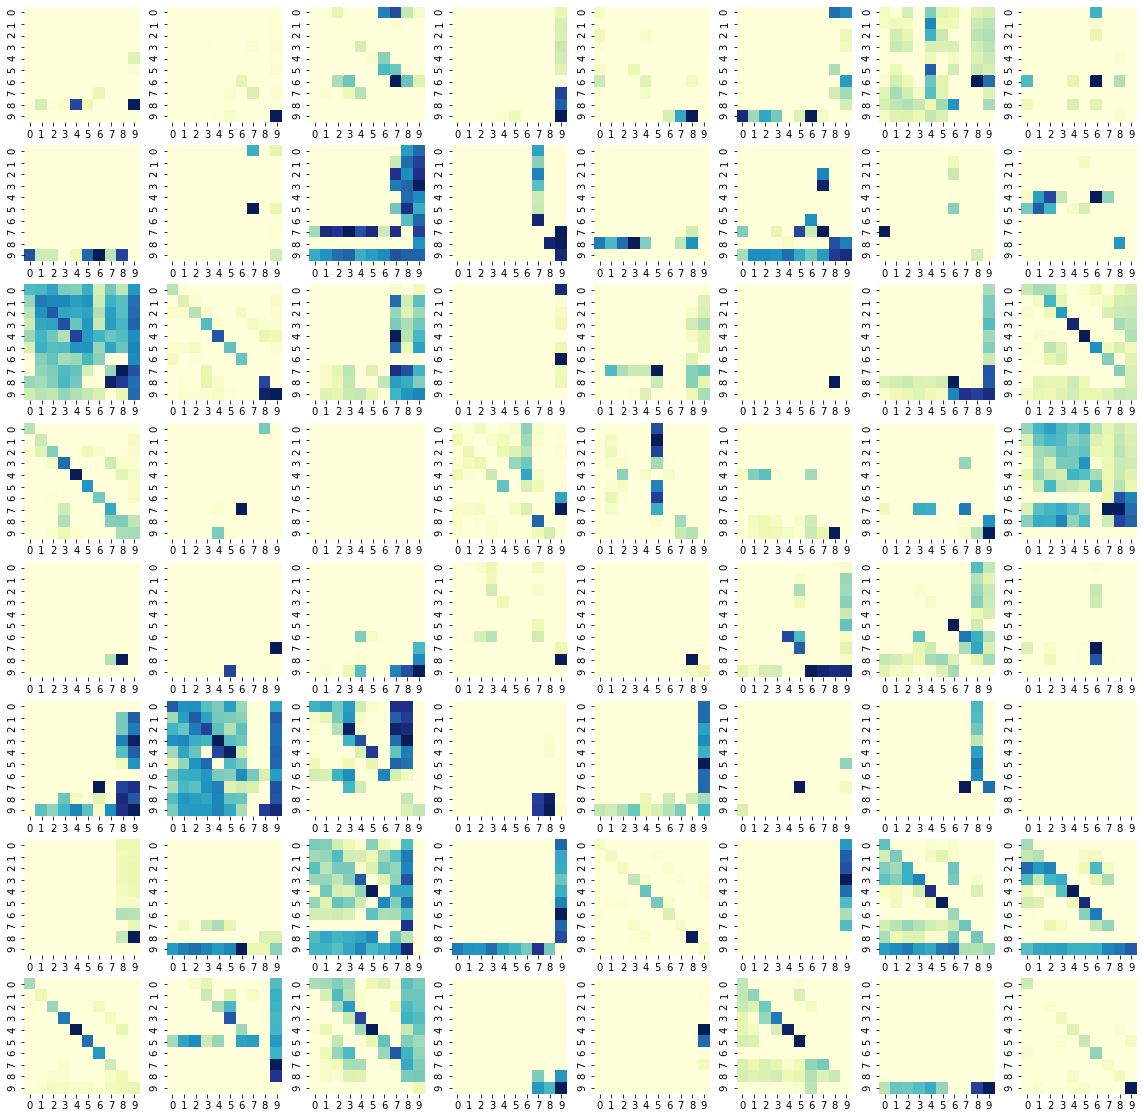

In [615]:
fig, axs = plt.subplots(8, 8, figsize=(20,20))
i = 0
for row in axs:
    for ax in row:
        sns.heatmap(layer_output[1][0,:10,:10,i], vmin=0, square=True, ax=ax, cmap="YlGnBu", cbar=False)
        i += 1

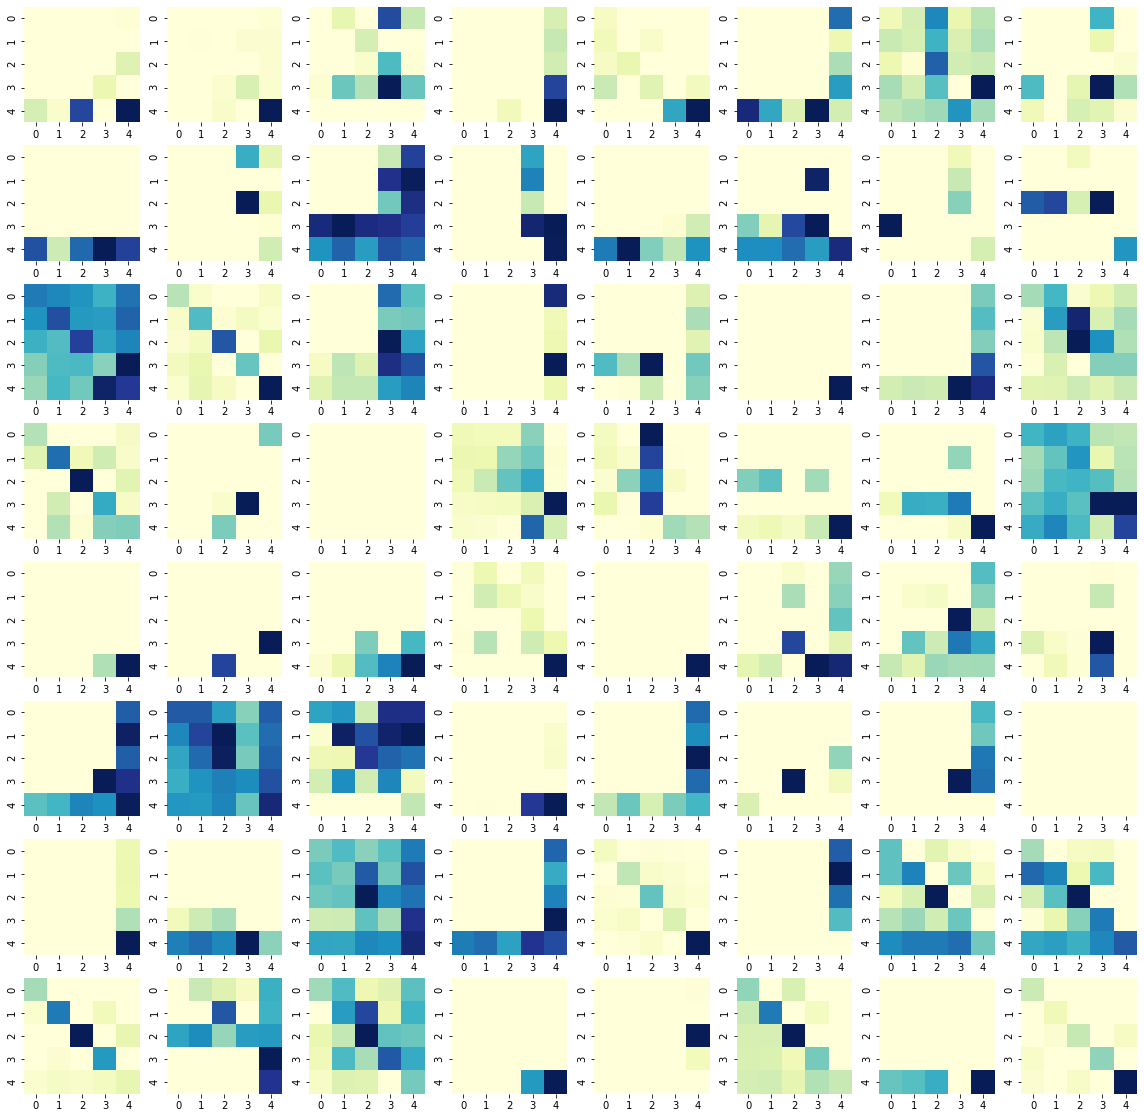

In [616]:
fig, axs = plt.subplots(8, 8, figsize=(20,20))
i = 0
for row in axs:
    for ax in row:
        sns.heatmap(layer_output[2][0,:5,:5,i], vmin=0, square=True, ax=ax, cmap="YlGnBu", cbar=False)
        i += 1

In [403]:
target = meta["uva.x004319990"]
rightindex, allsims = get_simmats(target['htid'], ann, (50,50,1))
predictions = get_model_predictions(rightindex, allsims)
data_entry = export_structured_data(target, predictions)
print(json.dumps(data_entry, indent=2))

{
  "volume": {
    "htid": "uva.x004319990",
    "title": "The picture of Dorian Gray / Oscar Wilde ; with an introduction by Edmund White.",
    "author": "Wilde, Oscar, 1854-1900.",
    "description": null,
    "rights_date_used": 1999.0,
    "oclc_num": "40754285",
    "isbn": "0192100319",
    "link": "http://hdl.handle.net/2027/uva.x004319990"
  },
  "related_metadata": {
    "other years": [
      1923.0,
      1957.0,
      2009.0,
      1909.0
    ],
    "other titles": [
      "The complete works of Oscar Wilde...",
      "The picture of Dorian Gray. With an introd. by Andre Maurois and illus. by Lucille Corcos.",
      "The picture of Dorian Gray / by Oscar Wilde ; illustrated by John Murphy.",
      "The complete works of Oscar Wilde."
    ],
    "other OCLC numbers": [
      "1717720",
      "11118570",
      "276141953",
      "3661072"
    ],
    "other enumchron values": [
      "v.4",
      NaN,
      "10"
    ],
    "titles within this work": [],
    "titles of works 

In [380]:
target = meta.random()
#target = meta['mdp.35112101274639']
rightindex, allsims = get_simmats(target['htid'], ann, (50,50,1))
predictions = get_model_predictions(rightindex, allsims)
data_entry = export_structured_data(target, predictions)
print(json.dumps(data_entry, indent=2))

{
  "volume": {
    "htid": "mdp.39015016369459",
    "title": "Safety; methods for preventing occupational and other accidents and disease, by William H. Tolman ... and Leonard B. Kendall ...",
    "author": "Tolman, William Howe, 1861-",
    "description": null,
    "rights_date_used": 1913.0,
    "oclc_num": "487038",
    "isbn": null,
    "link": "http://hdl.handle.net/2027/mdp.39015016369459"
  },
  "related_metadata": {
    "other years": [],
    "other titles": [],
    "other OCLC numbers": [],
    "other enumchron values": [
      NaN
    ],
    "titles within this work": [],
    "titles of works that contain this work": []
  },
  "relationships": {
    "identical works": [
      {
        "htid": "mdp.39015006497690",
        "title": "Safety; methods for preventing occupational and other accidents and disease, by William H. Tolman ... and Leonard B. Kendall ...",
        "author": "Tolman, William Howe, 1861-",
        "description": NaN,
        "year": 1913.0,
        "oclc

In [363]:
target = meta.random()
#target = meta['mdp.35112101274639']
rightindex, allsims = get_simmats(target['htid'], ann, (50,50,1))
predictions = get_model_predictions(rightindex, allsims)
data_entry = export_structured_data(target, predictions)
print(json.dumps(data_entry, indent=2))

{
  "volume": {
    "htid": "hvd.32044043445451",
    "title": "Islands of the southern seas : Hawaii, Samoa, New Zealand, Tasmania, Australia, and Java / by Michael Myers Shoemaker.",
    "author": "Shoemaker, Michael Myers, 1853-1924.",
    "description": null,
    "rights_date_used": 1898.0,
    "oclc_num": "14283381",
    "isbn": null
  },
  "related_metadata": {
    "other years": [],
    "other titles": [],
    "other OCLC numbers": [],
    "other enumchron values": [
      NaN
    ],
    "titles within this work": [],
    "titles of works that contain this work": []
  },
  "relationships": {
    "identical works": [
      {
        "htid": "nyp.33433082444617",
        "title": "Islands of the southern seas : Hawaii, Samoa, New Zealand, Tasmania, Australia, and Java / by Michael Myers Shoemaker.",
        "author": "Shoemaker, Michael Myers, 1853-1924.",
        "description": NaN,
        "year": 1898.0,
        "oclc_num": "14283381",
        "isbn": NaN,
        "confidence":

In [365]:
target = meta.random()
#target = meta['mdp.35112101274639']
rightindex, allsims = get_simmats(target['htid'], ann, (50,50,1))
predictions = get_model_predictions(rightindex, allsims)
data_entry = export_structured_data(target, predictions)
print(json.dumps(data_entry, indent=2))

{
  "volume": {
    "htid": "mdp.39015004182252",
    "title": "The master: a study of Arnold Bennett [by] Oswald H. Davis.",
    "author": "Davis, Oswald Harcourt, 1882-1962.",
    "description": null,
    "rights_date_used": 1966.0,
    "oclc_num": "2164508",
    "isbn": null
  },
  "related_metadata": {
    "other years": [
      1979.0
    ],
    "other titles": [
      "The master : a study of Arnold Bennett / Oswald H. Davis."
    ],
    "other OCLC numbers": [
      "5029454"
    ],
    "other enumchron values": [
      NaN
    ],
    "titles within this work": [],
    "titles of works that contain this work": []
  },
  "relationships": {
    "identical works": [
      {
        "htid": "uc1.$b85957",
        "title": "The master: a study of Arnold Bennett [by] Oswald H. Davis.",
        "author": "Davis, Oswald Harcourt, 1882-1962.",
        "description": NaN,
        "year": 1966.0,
        "oclc_num": "2164508",
        "isbn": NaN,
        "confidence": 65
      },
      {


In [382]:
import time
start = time.time()
with open('/tmp/test_dataset.txt', mode='a') as f:
    for i in range(100):
        if i:
            print(i, "Avg time per work: {}".format(int((time.time()-start)/i)))
        target = meta.random()
        f.write('\n\n{}\n\n'.format(target.title.upper().center(100, '=')))
        try:
            rightindex, allsims = get_simmats(target['htid'], ann, (50,50,1))
            predictions = get_model_predictions(rightindex, allsims)
        except:
            continue
        data_entry = export_structured_data(target, predictions)
        json.dump(data_entry, f, indent=2)

1 Avg time per work: 3
2 Avg time per work: 6
3 Avg time per work: 4
4 Avg time per work: 3
5 Avg time per work: 3
6 Avg time per work: 3
7 Avg time per work: 3
8 Avg time per work: 3
9 Avg time per work: 3
10 Avg time per work: 3
11 Avg time per work: 3
12 Avg time per work: 3
13 Avg time per work: 3
14 Avg time per work: 2
15 Avg time per work: 2
16 Avg time per work: 2
17 Avg time per work: 2
18 Avg time per work: 2
19 Avg time per work: 3
20 Avg time per work: 3
21 Avg time per work: 3
22 Avg time per work: 3
23 Avg time per work: 3
24 Avg time per work: 3
25 Avg time per work: 3
26 Avg time per work: 3
27 Avg time per work: 3
28 Avg time per work: 3
29 Avg time per work: 3
30 Avg time per work: 3
31 Avg time per work: 3
32 Avg time per work: 3
33 Avg time per work: 3
34 Avg time per work: 3
35 Avg time per work: 3
36 Avg time per work: 3
37 Avg time per work: 3
38 Avg time per work: 3
39 Avg time per work: 3
40 Avg time per work: 3
41 Avg time per work: 3
42 Avg time per work: 3
4